In [205]:
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

In [ ]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

In [240]:
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

def annotate_cpgs(segments):
    segments["CpGs"] = segments.apply(lambda row: set(reference_cpgs.get_CGs(row["chrom"], row["start"], row["end"])), axis=1)

In [241]:
ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"

gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
annotate_cpgs(gt)

In [242]:
""" Load the actual, measurable differential methylation in ground truth regions """
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"
with MetH5File(simulated_m5, "r") as simulated_m5, tqdm.tqdm(total=gt.shape[0]) as pbar:
    def compute_diffmet(chrom, start, end):
        agg = simulated_m5[chrom].get_values_in_range(start, end).get_llr_site_readgroup_rate("sample")
        diffmet = np.abs(np.nanmean(agg[1][0]) - np.nanmean(agg[2][0]))
        pbar.update(1)
        return diffmet
    gt["diffmet"] = gt.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [06:43<00:00, 16.93it/s]


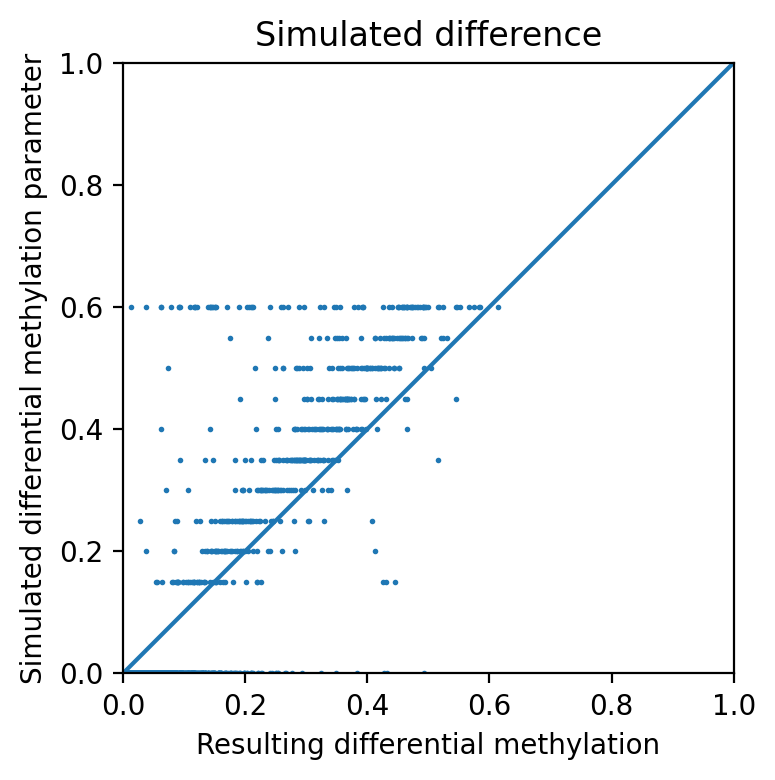

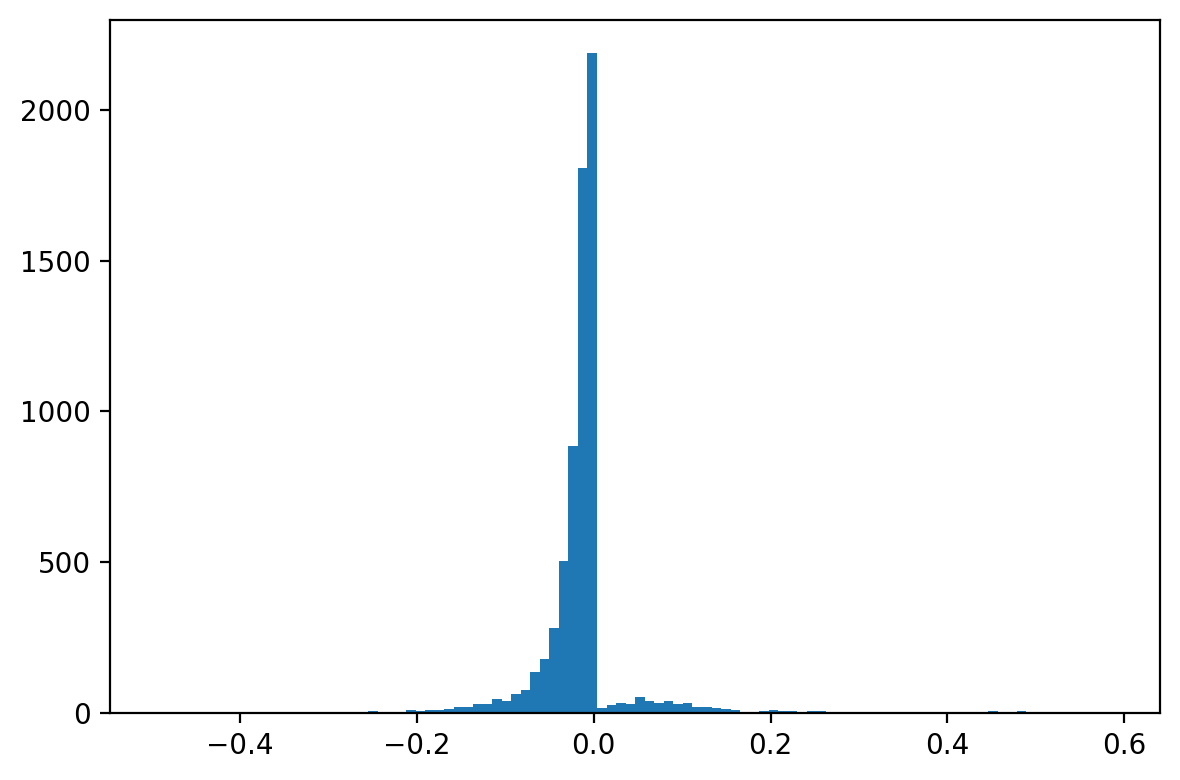

In [243]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(gt["diffmet"], np.abs(gt["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
plt.show()

pa.figure()
plt.hist(np.abs(gt["theta"]) - gt["diffmet"], bins=100)
plt.show()

In [317]:
methcp_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_dmr.bed"
methcp_dmrs = pd.read_csv(methcp_dmrs_file, sep="\t", names=["chrom", "start", "end", "nC.valid", "nC", "diffmet", "cov", "pval"], dtype={"chrom":str})
methcp_dmrs = methcp_dmrs.loc[(methcp_dmrs["nC.valid"]>10)]
annotate_cpgs(methcp_dmrs)

In [267]:
pycometh_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet.tsv"
pycometh_dmrs = pd.read_csv(pycometh_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_dmrs["diffmet"] = pycometh_dmrs["difference"].map(lambda x: float(x[1:-1]))
pycometh_dmrs = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.1].copy()
annotate_cpgs(pycometh_dmrs)

In [485]:
pycometh_llr_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_llrdiff.tsv"
pycometh_llr_dmrs = pd.read_csv(pycometh_llr_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_llr_dmrs["diffmet"] = pycometh_llr_dmrs["difference"].map(lambda x: float(x[1:-1]))
pycometh_llr_dmrs = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.1].copy()
annotate_cpgs(pycometh_llr_dmrs)

In [ ]:
class ResultComparer:
    def __init__(self, segments):
        self.segments = segments

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=diffmet_threshold, theta_threshold=0.1)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=diffmet_threshold, theta_threshold=0.1)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)
        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=diffmet_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=diffmet_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

In [336]:
rc = ResultComparer({"GT":gt, "MethCP":methcp_dmrs, "PycoMeth":pycometh_dmrs})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [230]:
rc.__class__ = ResultComparer

In [337]:
print("MethCP TPR", rc.compute_tpr("GT", "MethCP"))
print("MethCP FPR", rc.compute_fpr("GT", "MethCP"))
print("MethCP Precision", rc.compute_precision("GT",  "MethCP"))
print("MethCP FDR", rc.compute_fdr("GT", "MethCP"))

MethCP TPR 0.8708296228332929
MethCP FPR 0.003856700377532558
MethCP Precision 0.8902815839326111
MethCP FDR 0.07627227750087363


In [338]:
print("PycoMeth TPR", rc.compute_tpr("GT", "PycoMeth"))
print("PycoMeth FPR", rc.compute_fpr("GT",  "PycoMeth"))
print("PycoMeth Precision", rc.compute_precision("GT",  "PycoMeth"))
print("PycoMeth FDR", rc.compute_fdr("GT",  "PycoMeth"))



PycoMeth TPR 0.8891437515179318
PycoMeth FPR 0.004903412765985149
PycoMeth Precision 0.8696497540976396
PycoMeth FDR 0.09277425371492921


In [486]:
def plot_roc(gt, title=""):
    tools = {"MethCP":"b", "PycoMeth":"orange", "PycoMeth LLR": "red"}
    ps = 10**-np.arange(1, 10, 0.25)
    tpr = {t:[] for t in tools}
    precision = {t:[] for t in tools}
    for p in ps:
        filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<p].copy()
        filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<p].copy()
        filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<p].copy()
        rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr})
        rc.remove_cpgs_not_in_gt(gt_key="GT")
        for tool in tools:
            tpr[tool].append(rc.compute_tpr("GT", tool))
            precision[tool].append(rc.compute_precision("GT", tool))

    o5_index = np.argmin(np.abs((ps-0.05)))

    pa.figure()
    plt.title(title)
    for tool, color in tools.items():
        plt.plot(precision[tool],tpr[tool], label=tool, c=color)
        plt.scatter([precision[tool][o5_index]], [tpr[tool][o5_index]], c=color)
    plt.legend()
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect("equal")
    plt.show()


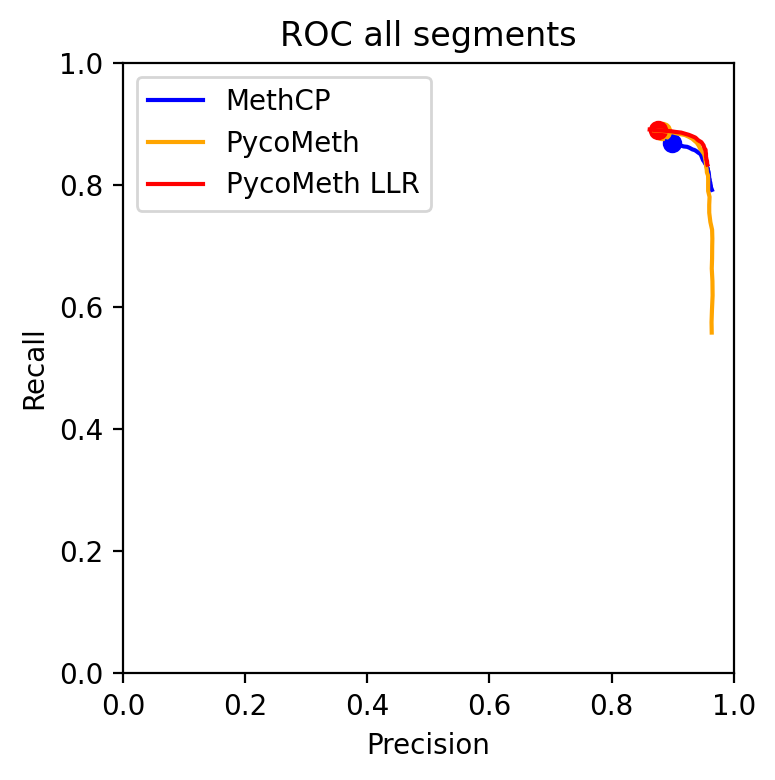

In [488]:
plot_roc(gt, "ROC all segments")

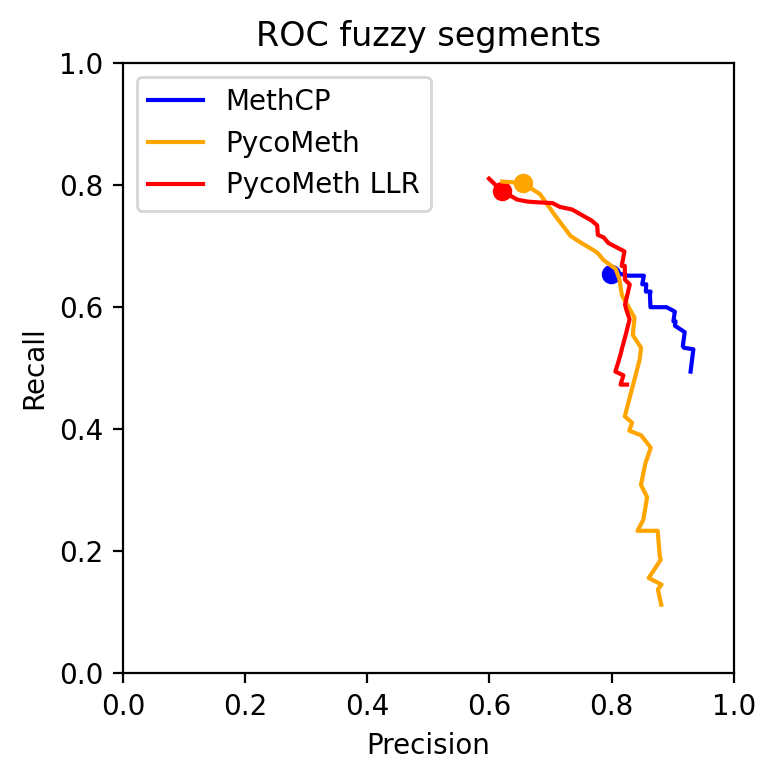

In [487]:
plot_roc(gt.loc[gt["segment_type"]==3].copy(), "ROC fuzzy segments")

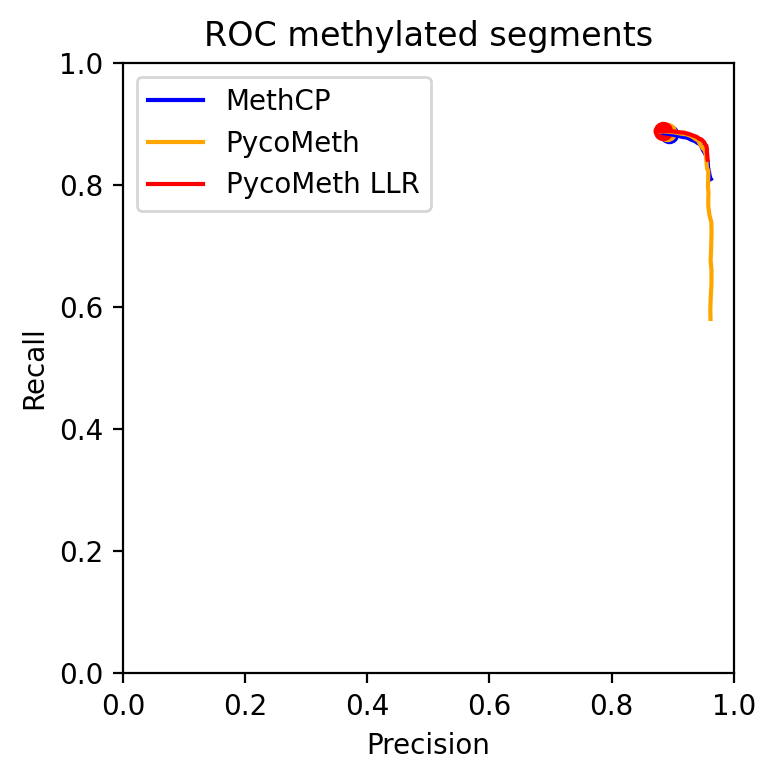

In [489]:
plot_roc(gt.loc[gt["segment_type"]==2].copy(), "ROC methylated segments")

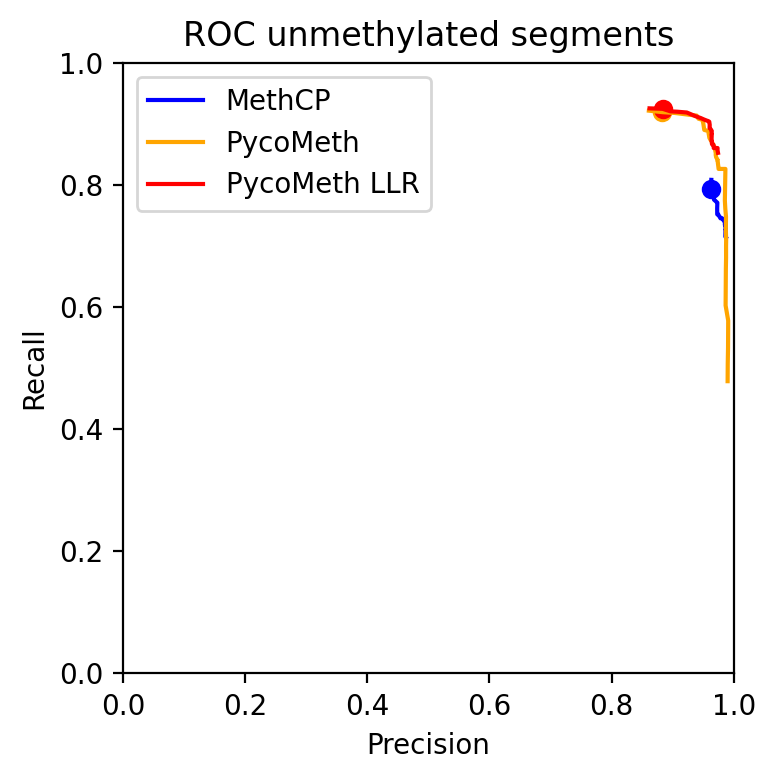

In [490]:
plot_roc(gt.loc[gt["segment_type"]==1].copy(), "ROC unmethylated segments")

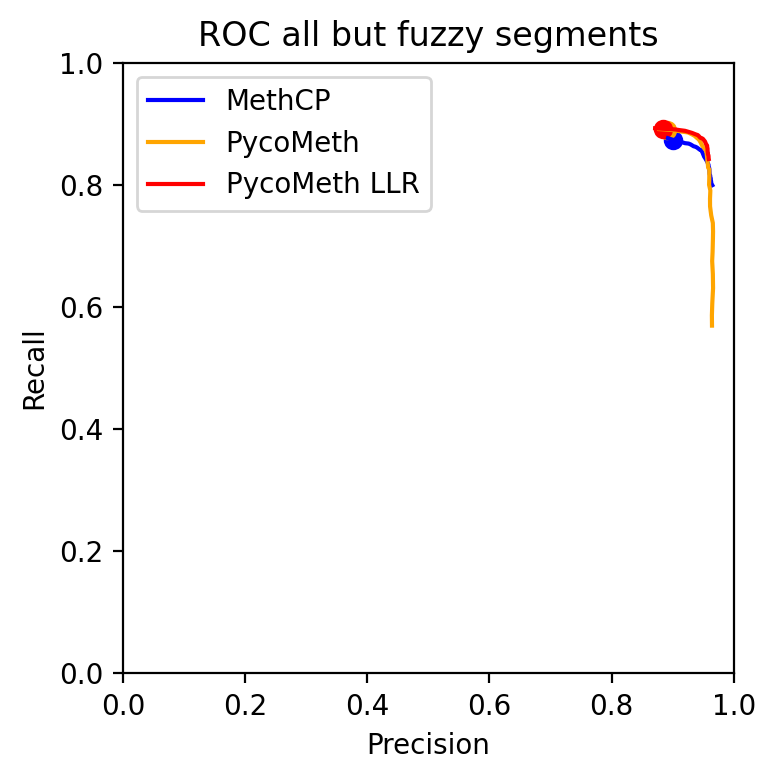

In [491]:
plot_roc(gt.loc[gt["segment_type"]!=3].copy(), "ROC all but fuzzy segments")

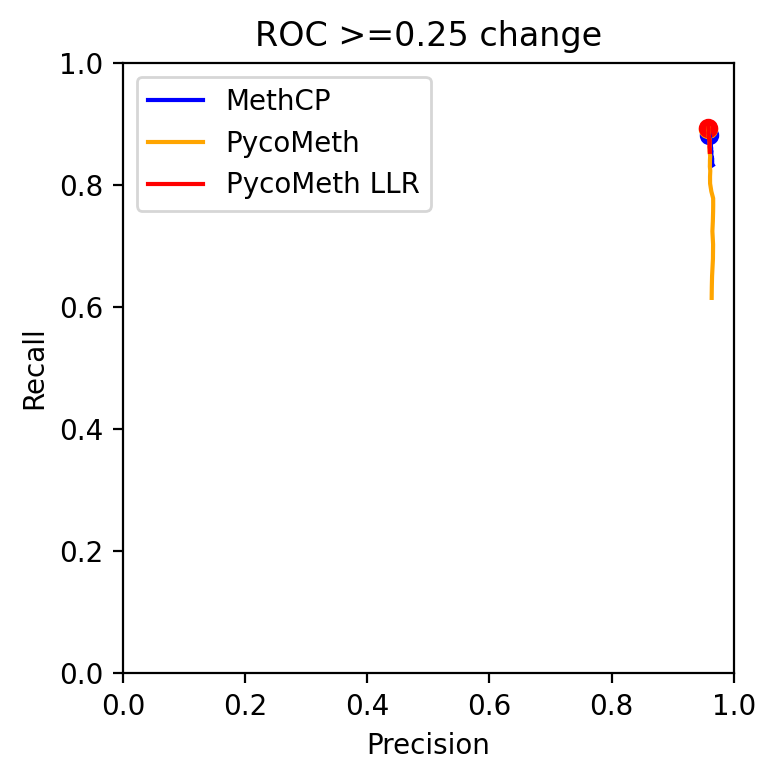

In [492]:
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), "ROC >=0.25 change")

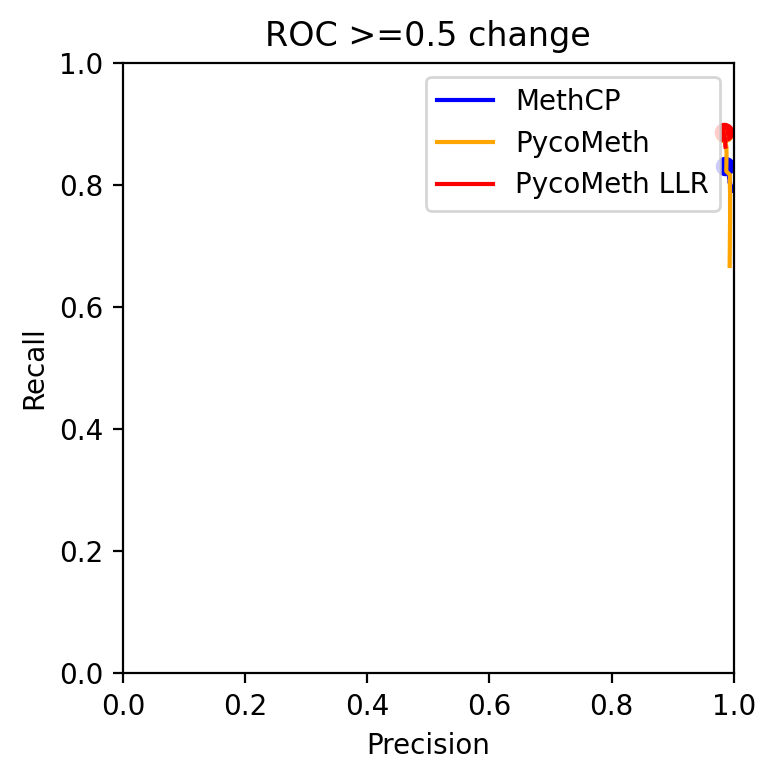

In [494]:
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), "ROC >=0.5 change")

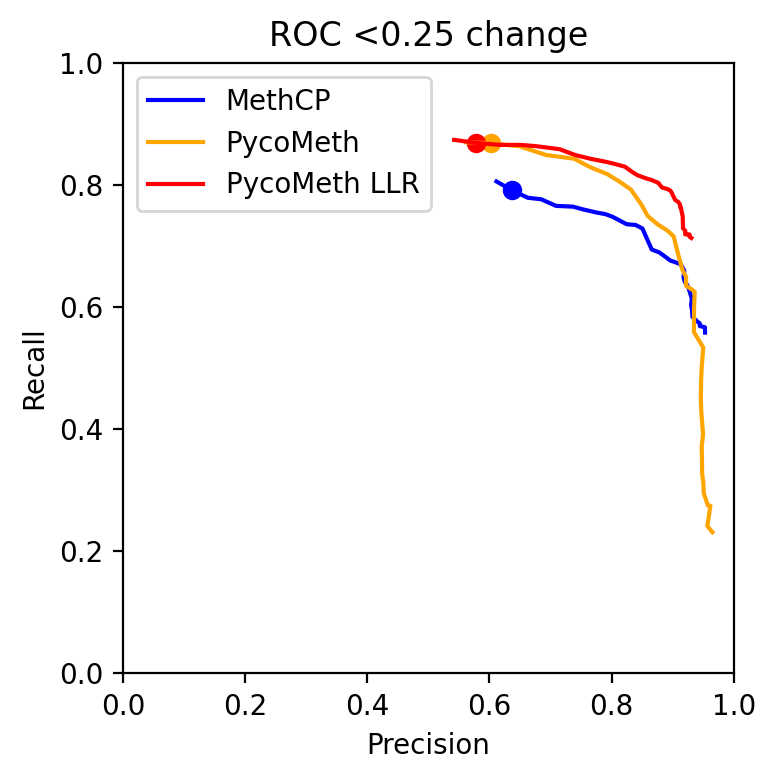

In [495]:
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "ROC <0.25 change")
